In [1]:
import numpy as np

from scipy import misc
from itertools import product
from functools import partial
from matplotlib import pyplot as plt

In [2]:
def plot_function(X, Y):
    plt.plot(X, Y)
    
    plt.grid()
    plt.show()

In [3]:
def gaussian_func(dist, sigma):
    return np.exp(-dist**2 / (2*sigma**2))

def mexicanhat_func(dist, sigma):
    return (1 - (dist**2 / sigma**2)) * np.exp(-dist**2 / (2*sigma**2))

def triangular_func(dist, sigma):
    return np.array([(1 - abs(d) / sigma) if abs(d) <= sigma else 0 for d in dist])

def rectangular_func(dist, sigma):
    return np.array([1 if abs(d) <= sigma else 0 for d in dist])

def circular_distance(x, y, length):
    return min((x-y)%length, (y-x)%length)

In [4]:
class SOM(object):
    def __init__(self, output_shape=(3, 3), weight_comp=None, neighbor_dist=None, dist_scaling=None):
        self._output_shape = output_shape
        self._num_weights = np.prod(output_shape)
        self._weight_comp = None
        self._codebook = None
        self._weights = None
        
        if weight_comp is not None:
            self._weight_comp = weight_comp
        else:
            self._weight_comp = lambda w, x: np.linalg.norm(w - x, 2, axis=1)
            
        if neighbor_dist is not None:
            self._neighbor_dist = neighbor_dist
        else:
            self._neighbor_dist = lambda wp, op: np.linalg.norm(wp - op, 1, axis=1)
            
        if dist_scaling is not None:
            self._dist_scaling = dist_scaling
        else:
            self._dist_scaling = lambda d, sigma: rectangular_func(d, sigma)
        
    def _init_weights(self, weight_size=3):
        weight_positions = [range(x) for x in self._output_shape]
        self._codebook = np.array([np.array(x) for x in product(*weight_positions)])
        self._weights = np.random.rand(self._num_weights, weight_size)
    
    def train(self, X, max_iter, eta0, sigma0, verbose=False):
        self._init_weights(X.shape[1])
        print_step = int(0.1 * max_iter)
        
        for idx in xrange(1, max_iter+1):
            eta = eta0 * np.exp(-float(idx) / max_iter)
            sigma = sigma0 * np.exp(-float(idx*np.log2(sigma0)) / max_iter)
            if verbose and idx % print_step == 0:
                print 'Iter: ', idx, 'Eta: ', eta, ' Sigma: ', sigma
            for x in X:
                dists = self._weight_comp(self._weights, x)
                winner_idx = np.argmin(dists)
                winner_pos = self._codebook[winner_idx]
                dist_to_winner = self._neighbor_dist(winner_pos, self._codebook)
                dist_scaling = self._dist_scaling(dist_to_winner, sigma).reshape(-1, 1)
                self._weights += eta * dist_scaling * (x - self._weights)
                
    def map_data(self, X):
        return np.array([np.argmin(self._weight_comp(self._weights, x)) for x in X])
    
    def closest_weight(self, X):
        return np.array([self._weights[np.argmin(self._weight_comp(self._weights, x))] for x in X])

## KTH Experiments

#### Animals

In [22]:
with open('animals.csv') as fd:
    data = np.array([line.strip().split(',') for line in fd])
    X = data[:, :-1].astype(np.int32)
    Y = np.array(data[:, -1])

In [29]:
som = SOM(output_shape=(10, 10))
som.train(X, 30, 0.2, 50)
mapped = som.map_data(X)
mapped_ord = np.argsort(mapped)
print Y[mapped_ord]

['antelop' 'ape' 'bat' 'bear' 'beetle' 'butterfly' 'camel' 'cat'
 'crocodile' 'dog' 'dragonfly' 'duck' 'elephant' 'frog' 'giraffe'
 'grasshopper' 'horse' 'housefly' 'hyena' 'kangaroo' 'lion' 'moskito'
 'ostrich' 'pelican' 'penguin' 'pig' 'rabbit' 'rat' 'seaturtle' 'skunk'
 'spider' 'walrus']
[71 20 84 22 99 79 90 41 15 43 97 37  1  7 91 99 60 79 34 82 40 87 49 38 19
 80 93 55 25 63 68  3]
[12 31 13  8 24  1  3 28 18 11 23 20  7  9 22 27 16 29 30  0 17  5 25 19  2
 21  6 14 26 10  4 15]
['elephant' 'walrus' 'frog' 'crocodile' 'penguin' 'ape' 'bear' 'seaturtle'
 'hyena' 'duck' 'pelican' 'lion' 'cat' 'dog' 'ostrich' 'rat' 'horse'
 'skunk' 'spider' 'antelop' 'housefly' 'butterfly' 'pig' 'kangaroo' 'bat'
 'moskito' 'camel' 'giraffe' 'rabbit' 'dragonfly' 'beetle' 'grasshopper']


#### Cities

In [10]:
with open('cities.csv') as fd:
    X = np.array([line.strip().split(',') for line in fd], dtype=np.float32)

In [11]:
shape = (10,)
circular_dist = np.vectorize(lambda x, y: partial(circular_distance, length=10)(x, y))
som = SOM(output_shape=shape, neighbor_dist=circular_dist)
som.train(X, 2500, 0.2, 2, True)
W = som._weights
tour = np.vstack((W, W[0,:]))

Iter:  250 Eta:  0.180967483607  Sigma:  1.80967483607
Iter:  500 Eta:  0.163746150616  Sigma:  1.63746150616
Iter:  750 Eta:  0.148163644136  Sigma:  1.48163644136
Iter:  1000 Eta:  0.134064009207  Sigma:  1.34064009207
Iter:  1250 Eta:  0.121306131943  Sigma:  1.21306131943
Iter:  1500 Eta:  0.109762327219  Sigma:  1.09762327219
Iter:  1750 Eta:  0.0993170607583  Sigma:  0.993170607583
Iter:  2000 Eta:  0.0898657928234  Sigma:  0.898657928234
Iter:  2250 Eta:  0.0813139319481  Sigma:  0.813139319481
Iter:  2500 Eta:  0.0735758882343  Sigma:  0.735758882343


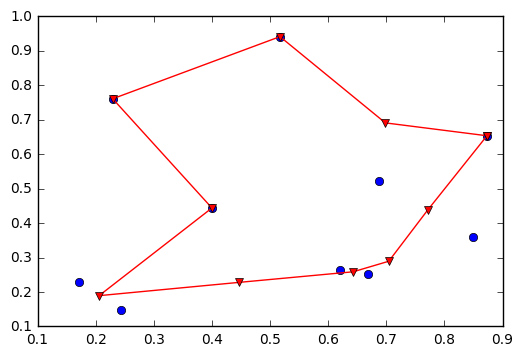

In [12]:
plt.plot(X[:, 0], X[:, 1], 'ob')
plt.plot(tour[:, 0], tour[:, 1], marker='v', color='r')
plt.show()

#### Parties

In [13]:
with open('votes.csv') as fd:
    data = np.array([line.strip().split(',') for line in fd])
    
    X = np.array(data[:, :-4]).astype(np.float32)
    Ys = np.array(data[:, -4:])

In [14]:
shape = (10, 10)
som = SOM(output_shape=shape)
som.train(X, 1000, 0.2, 5, True)
mapped = som.map_data(X)

Iter:  100 Eta:  0.180967483607  Sigma:  3.96396625254
Iter:  200 Eta:  0.163746150616  Sigma:  3.14260569026
Iter:  300 Eta:  0.148163644136  Sigma:  2.49143658024
Iter:  400 Eta:  0.134064009207  Sigma:  1.97519410489
Iter:  500 Eta:  0.121306131943  Sigma:  1.5659205548
Iter:  600 Eta:  0.109762327219  Sigma:  1.24145124668
Iter:  700 Eta:  0.0993170607583  Sigma:  0.9842141692
Iter:  800 Eta:  0.0898657928234  Sigma:  0.780278350396
Iter:  900 Eta:  0.0813139319481  Sigma:  0.618599409712
Iter:  1000 Eta:  0.0735758882343  Sigma:  0.490421436788


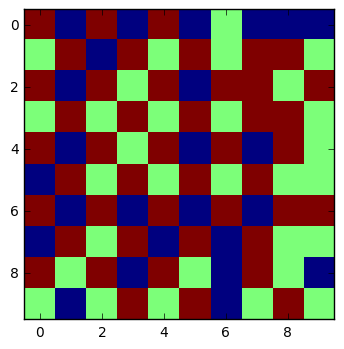

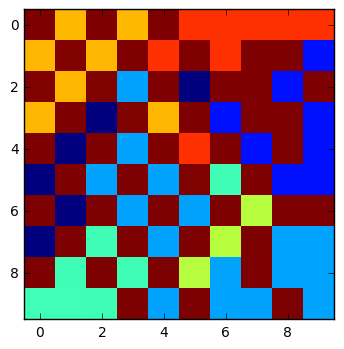

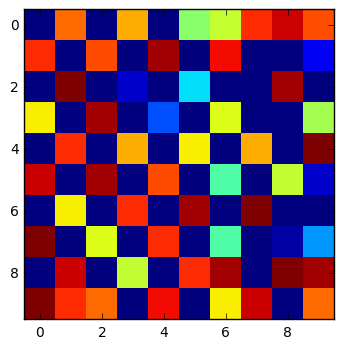

In [15]:
a = np.ones(np.prod(shape), dtype=np.int32) * 349 #431
a.flat[mapped] = range(0, 349)

# us_votes v, n, s, p, d
Y_p = np.append(Ys[:, -3], 2)
sex_im = Y_p[a].reshape(shape).astype(np.float32)
plt.imshow(sex_im, interpolation='nearest') #, cmap='gray')
plt.show()

Y_p = np.append(Ys[:, 2], 8)
part_im = Y_p[a].reshape(shape).astype(np.float32)
plt.imshow(part_im, interpolation='none') #, cmap='gray')
plt.show()

Y_p = np.append(Ys[:, 3], 0)
district_im = Y_p[a].reshape(shape).astype(np.float32) / 29.0
plt.imshow(district_im, interpolation='none') #, cmap='gray')
plt.show()

#### Color Quantization

Iter:  3 Eta:  0.0904837418036  Sigma:  1.25171311136
Iter:  6 Eta:  0.0818730753078  Sigma:  1.20521977935
Iter:  9 Eta:  0.0740818220682  Sigma:  1.16045338453
Iter:  12 Eta:  0.0670320046036  Sigma:  1.11734978196
Iter:  15 Eta:  0.0606530659713  Sigma:  1.07584720927
Iter:  18 Eta:  0.0548811636094  Sigma:  1.03588619821
Iter:  21 Eta:  0.0496585303791  Sigma:  0.997409489369
Iter:  24 Eta:  0.0449328964117  Sigma:  0.960361950186
Iter:  27 Eta:  0.0406569659741  Sigma:  0.924690495925
Iter:  30 Eta:  0.0367879441171  Sigma:  0.890344013617


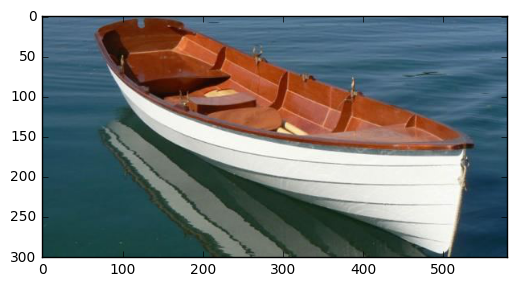

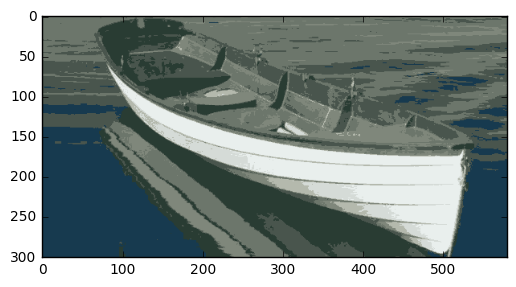

In [31]:
# load na prepare data
img_c = misc.imread('img4.jpg') / 255.
img_shape = img_c.shape
X = img_c.reshape(img_shape[0]*img_shape[1], img_shape[2])

# create som and quantize data
som = SOM(output_shape=(8,), dist_scaling=rectangular_func)
som.train(X, 30, 0.1, 1.3, True)
quantized = som.closest_weight(X)
img_q = quantized.reshape(img_shape)

# plot original
plt.imshow(img_c)
plt.show()

# plot quantized
plt.imshow(img_q)
plt.show()